### - Plot model predictions for the three types of features: CellProfiler, CP-CNN, DINO on Precision-Recall AUC score and ROC-AUC scores;

#### - Profiling assays PR-AUC & ROC-AUC scores visualization
#### - Individual MOA predictions found in Test data set



#### - PR-AUC was the primary evaluation metric because it takes into account the practically relevant measures, **precision and recall,** of which precision is particularly important because it measures the fraction of correct predictions among the positive predictions. 

#### - Also, PR-AUC score express the susceptibility of classifiers to imbalanced datasets, since the position of the random baseline depends on the ratio of the numbers of positive and negative instances. [read more](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)

This script is adapted from Gregory Way, Adeniyi Adeboye, & Shantanu Singh. (2022). broadinstitute/lincs-profiling-complementarity: Response to Reviewers (Version v2). Zenodo. https://doi.org/10.5281/zenodo.6522802

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import median
import random
sns.set_context("talk")
sns.set_style("darkgrid")
from collections import Counter

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics import log_loss, roc_curve
from sklearn.metrics import auc

In [3]:
from adjustText import adjust_text

In [4]:
drop_bortezomib_from_test = True

In [5]:
base_dir = pathlib.Path("/scr/lanfang/Dino4Cells_analysis/dino-cp-analysis/model_data")

file_dino = "_dino_final"
file_cp = "_cellprofiler_final"
file_cnn = "_CNN_final"

cp_data_dir = pathlib.Path(f"{base_dir}/")



In [6]:
cp_test_cellpro = f"{cp_data_dir}/test_data{file_cp}.csv.gz"
cp_test_CNN = f"{cp_data_dir}/test_data{file_cnn}.csv.gz"
cp_test_dino = f"{cp_data_dir}/test_data{file_dino}.csv.gz"

In [7]:
result_dir = '/scr/lanfang/Dino4Cells_analysis/dino-cp-analysis/07-moa-classification/prediction'

model_preds_cp = pathlib.Path(f"{result_dir}/cellprofiler/")
model_preds_CNN = pathlib.Path(f"{result_dir}/cnn/")
model_preds_dino = pathlib.Path(f"{result_dir}/dino/")

model_preds_figures = pathlib.Path(f"{result_dir}/figures")

In [8]:
df_cp_test_cellpro = pd.read_csv(cp_test_cellpro, compression='gzip',low_memory = False)
df_cp_test_CNN = pd.read_csv(cp_test_CNN, compression='gzip',low_memory = False)
df_cp_test = pd.read_csv(cp_test_dino, compression='gzip',low_memory = False)

# Drop Bortezomib from test sets
if drop_bortezomib_from_test:
    print("dropping bortezomib from all test sets!")
    df_cp_test = df_cp_test.loc[df_cp_test.pert_iname != 'bortezomib', :]
    df_cp_test_cellpro = df_cp_test_cellpro.loc[df_cp_test_cellpro.pert_iname != 'bortezomib', :]
    df_cp_test_CNN = df_cp_test_CNN.loc[df_cp_test_CNN.pert_iname != 'bortezomib', :]


dropping bortezomib from all test sets!


In [9]:
print(df_cp_test.shape)
print(df_cp_test_cellpro.shape)
print(df_cp_test_CNN.shape)

len(list(df_cp_test_cellpro['pert_iname'].unique()))

(1865, 943)
(1865, 1365)
(1865, 1232)


385

In [10]:
##resnet
df_cp_resnet_test = pd.read_csv(os.path.join(model_preds_dino, 'cp_test_pathway_preds_resnet.csv'))
df_cp_resnet_test_cellpro = pd.read_csv(os.path.join(model_preds_cp, 
                                                     'cp_test_pathway_preds_resnet.csv'))
df_cp_resnet_test_CNN = pd.read_csv(os.path.join(model_preds_CNN, 'cp_test_pathway_preds_resnet.csv'))

# Drop bortezomib from evaluation
if drop_bortezomib_from_test:
    df_cp_resnet_test = df_cp_resnet_test.iloc[df_cp_test.index, :]
    df_cp_resnet_test_cellpro = df_cp_resnet_test_cellpro.iloc[df_cp_test_cellpro.index, :]
    df_cp_resnet_test_CNN = df_cp_resnet_test_CNN.iloc[df_cp_test_CNN.index, :]

##### - Shuffled test predictions

In [11]:
##resnet shuffle
df_cp_resnet_shuf = pd.read_csv(os.path.join(model_preds_dino, 
                                             'cp_test_pathway_preds_resnet_shuffle.csv'))
df_cp_resnet_shuf_cellpro = pd.read_csv(os.path.join(model_preds_cp, 
                                                     'cp_test_pathway_preds_resnet_shuffle.csv'))

df_cp_resnet_shuf_CNN = pd.read_csv(os.path.join(model_preds_CNN, 
                                                 'cp_test_pathway_preds_resnet_shuffle.csv'))

# Drop bortezomib from evaluation
if drop_bortezomib_from_test:
    df_cp_resnet_shuf = df_cp_resnet_shuf.iloc[df_cp_test.index, :]
    df_cp_resnet_shuf_cellpro = df_cp_resnet_shuf_cellpro.iloc[df_cp_test_cellpro.index, :]
    df_cp_resnet_shuf_CNN = df_cp_resnet_shuf_CNN.iloc[df_cp_test_CNN.index, :]

In [12]:
def get_moa_list(df_tst, df_tst_y):
    moa_class_list = df_tst['moa'].unique()
    val_moas = [moa for moa_list in moa_class_list for moa in moa_list.split('|')]
    
    copy_ls = val_moas.copy()
    for col in copy_ls:
        if col not in df_tst_y.columns:
            val_moas.remove(col)
        else:
            sum_col = df_tst_y[col].sum()
        if sum_col == 0:
            val_moas.remove(col)
    val_moas = list(set(val_moas))
    return val_moas

In [13]:
df_cp_tst_targets = df_cp_test[df_cp_resnet_test.columns]
df_cp_tst_targets_cellpro = df_cp_test_cellpro[df_cp_resnet_test.columns]
df_cp_tst_targets_CNN = df_cp_test_CNN[df_cp_resnet_test.columns]

In [14]:
val_moas = get_moa_list(df_cp_test, df_cp_tst_targets)

##### - Baseline of Precision-Recall AUC score is determined by the ratio of positives (P i.e. 1) to ratio of positives (P i.e. 1) and negatives (N i.e. 0) i.e. y = P / (P + N)

In [15]:
def calculate_baseline(df, val_moas=val_moas):
    """Calculate the PR- baseline (i.e. P/P+N) for each profiling assay"""
    targts = np.ravel(df[val_moas].values)
    targts_one = [values for num in np.where(targts == 1) for values in num]
    baseline = len(targts_one) / len(targts)
    return baseline

In [16]:
cp_no_skill = calculate_baseline(df_cp_tst_targets)
cp_no_skill

0.0041724880111769815

In [17]:
def evaluate(actual, pred, val_moas):
    """Evaluate model performance using ROC-AUC and PR-AUC scores"""
    rocauc_score = roc_auc_score(actual[val_moas], pred[val_moas], average='macro')
    pr_auc_score = average_precision_score(actual[val_moas], pred[val_moas], average="micro")
    return [rocauc_score, pr_auc_score]

In [18]:
cp_preds = [df_cp_resnet_test, df_cp_resnet_shuf]

cp_preds_cellpro = [df_cp_resnet_test_cellpro, df_cp_resnet_shuf_cellpro]
                  
cp_preds_CNN = [df_cp_resnet_test_CNN, df_cp_resnet_shuf_CNN]

metrics = ['roc_auc_score', 'pr_auc_score',]

model_name = ['_resnet', '_resnetshuf']

targets_dfs = [df_cp_tst_targets_cellpro, df_cp_tst_targets_CNN, df_cp_tst_targets]

assays = ['CellProfiler','CP-CNN','ViTS']

preds_all = [cp_preds_cellpro, cp_preds_CNN, cp_preds]

#### - All models predictions

In [19]:
##models predictions for all profiling assays
score_dict = {}
for idx, (assay_name, actual_df) in enumerate(zip(assays, targets_dfs)):
    for mdl, pred_df in zip(model_name, preds_all[idx]):
        model_score = {}
        score_name = assay_name + mdl
        eval_list = evaluate(actual_df, pred_df, val_moas)
        for io, met in enumerate(metrics):
            score_dict[score_name] = model_score
            score_dict[score_name][met] = eval_list[io]

In [20]:
df_pred_scores = pd.DataFrame([(k,k1,v1) for k,v in score_dict.items() for k1,v1 in v.items()], 
                              columns = ['id_name', 'metrics', 'values'])

In [21]:
df_pred_scores

,id_name,metrics,values
0,CellProfiler_resnet,roc_auc_score,0.682454
1,CellProfiler_resnet,pr_auc_score,0.067849
2,CellProfiler_resnetshuf,roc_auc_score,0.490857
3,CellProfiler_resnetshuf,pr_auc_score,0.008685
4,CP-CNN_resnet,roc_auc_score,0.704842
5,CP-CNN_resnet,pr_auc_score,0.075063
6,CP-CNN_resnetshuf,roc_auc_score,0.511697
7,CP-CNN_resnetshuf,pr_auc_score,0.008738
8,ViTS_resnet,roc_auc_score,0.690005
9,ViTS_resnet,pr_auc_score,0.077292


In [22]:
df_pred_scores['profile_tech'] = df_pred_scores['id_name'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_pred_scores['model'] = df_pred_scores['id_name'].apply(lambda x: x.split('_')[-1])
df_pred_scores['values'] = df_pred_scores['values'].apply(lambda x: x*100)

In [23]:
df_pred_scores['model'].unique()

array(['resnet', 'resnetshuf'], dtype=object)

In [24]:
# normal_models = ['mlknn', 'resnet', 'cnn', 'tabnet', 'simplenn', 'blend']
# shuffle_models = ['mlknnshuf', 'resnetshuf', 'cnnshuf', 'tabnetshuf', 'simplennshuf']
normal_models = ['resnet']
shuffle_models = ['resnetshuf']

In [25]:
df_score_normal = df_pred_scores.loc[df_pred_scores['model'].isin(normal_models)].reset_index(drop=True)
df_score_shuffle = df_pred_scores.loc[df_pred_scores['model'].isin(shuffle_models)].reset_index(drop=True)

In [26]:
df_score_normal

,id_name,metrics,values,profile_tech,model
0,CellProfiler_resnet,roc_auc_score,68.245423,CellProfiler,resnet
1,CellProfiler_resnet,pr_auc_score,6.784930,CellProfiler,resnet
2,CP-CNN_resnet,roc_auc_score,70.484173,CP-CNN,resnet
3,CP-CNN_resnet,pr_auc_score,7.506310,CP-CNN,resnet
4,ViTS_resnet,roc_auc_score,69.000519,ViTS,resnet
5,ViTS_resnet,pr_auc_score,7.729156,ViTS,resnet


In [27]:
normal_model_names = {'resnet':'ResNet', 'cnn':'1D-CNN', 'tabnet':'TabNet', 'simplenn':'Simple NN', 'mlknn': 'Ml-KNN', 'blend': 'Models Ensemble'}
shuffle_model_names = {'resnetshuf':'ResNet', 'cnnshuf':'1D-CNN', 'tabnetshuf':'TabNet', 'simplennshuf':'Simple NN','mlknnshuf': 'Ml-KNN'}

def rename_col_values(df, model_name_dict):
    """Rename unique column values"""
    df['metrics'] = df['metrics'].map({'pr_auc_score': 'Precision-Recall_AUC', 'roc_auc_score': 'ROC_AUC'})
    df['model'] = df['model'].map(model_name_dict)
    df['profile_tech'] = df['profile_tech'].map({'L1000':'L1000','ViTS':'DINO_ViT_Small', 'CellProfiler': "Cell Profiler", 'CP-CNN':'Cell Painting CNN', 'ViTB':'DINO_ViT_Base'})
    return df

In [28]:
df_score_normal = rename_col_values(df_score_normal, normal_model_names)
df_score_shuffle = rename_col_values(df_score_shuffle, shuffle_model_names)

In [29]:
def extract_new_dfs(df):
    """Extract ROC-AUC & PR-AUC dataframes"""
    df_roc = df[df['metrics'] == 'ROC_AUC'].copy()
    df_pr_auc = df[df['metrics'] == 'Precision-Recall_AUC'].copy()
    return df_roc, df_pr_auc

In [30]:
df_roc_normal, df_pr_auc_normal = extract_new_dfs(df_score_normal)
df_roc_shuffle, df_pr_auc_shuffle = extract_new_dfs(df_score_shuffle)

In [31]:
# Output files
full_results_df = pd.concat([
    df_pr_auc_normal.assign(shuffle=False),
    df_roc_normal.assign(shuffle=False),
    df_pr_auc_shuffle.assign(shuffle=True),
    df_roc_shuffle.assign(shuffle=True)
])

output_file = pathlib.Path(f"{result_dir}/all_performance_metrics_resnet_final_v3.csv")
full_results_df.to_csv(output_file, index=False)

print(full_results_df.shape)
full_results_df

(12, 6)


,id_name,metrics,values,profile_tech,model,shuffle
1,CellProfiler_resnet,Precision-Recall_AUC,6.784930,Cell Profiler,ResNet,False
3,CP-CNN_resnet,Precision-Recall_AUC,7.506310,Cell Painting CNN,ResNet,False
5,ViTS_resnet,Precision-Recall_AUC,7.729156,DINO_ViT_Small,ResNet,False
0,CellProfiler_resnet,ROC_AUC,68.245423,Cell Profiler,ResNet,False
2,CP-CNN_resnet,ROC_AUC,70.484173,Cell Painting CNN,ResNet,False
4,ViTS_resnet,ROC_AUC,69.000519,DINO_ViT_Small,ResNet,False
1,CellProfiler_resnetshuf,Precision-Recall_AUC,0.868481,Cell Profiler,ResNet,True
3,CP-CNN_resnetshuf,Precision-Recall_AUC,0.873793,Cell Painting CNN,ResNet,True
5,ViTS_resnetshuf,Precision-Recall_AUC,0.890751,DINO_ViT_Small,ResNet,True
0,CellProfiler_resnetshuf,ROC_AUC,49.085678,Cell Profiler,ResNet,True


### - Plot Models -- Normal, Shuffle Models

##### - Baseline of Precision-Recall AUC score is determined by the ratio of positives (P i.e. 1) to ratio of positives (P i.e. 1) and negatives (N i.e. 0) i.e. y = P / (P + N)

In [32]:
pr_baseline = cp_no_skill

In [33]:
pr_baseline

0.0041724880111769815

In [34]:
def plot_model_predictions(df, baseline, file_name, txt_cord_y = 0.51, y_label= "Precision-Recall AUC %", title_label="Precision-Recall AUC score for all models", 
                           path = model_preds_figures):
  """Plot model predictions for all profiling assays"""
  if not os.path.exists(path):
        os.mkdir(path)
  cat_plt = sns.catplot(x="model", y="values", 
                        hue="profile_tech", data=df, kind="bar", palette='gray', 
                        height=6, aspect=2)
  cat_plt._legend.set_title('')
  cat_plt.set_axis_labels("Models", y_label)
  cat_plt.fig.suptitle(title_label)
  cat_plt.fig.subplots_adjust(top=.91)
  plt.axhline(baseline, ls='--', linewidth=3, color='red')
  plt.text(-0.42,txt_cord_y, "Baseline", color='red')
  plt.savefig(os.path.join(path, file_name))
  plt.show()

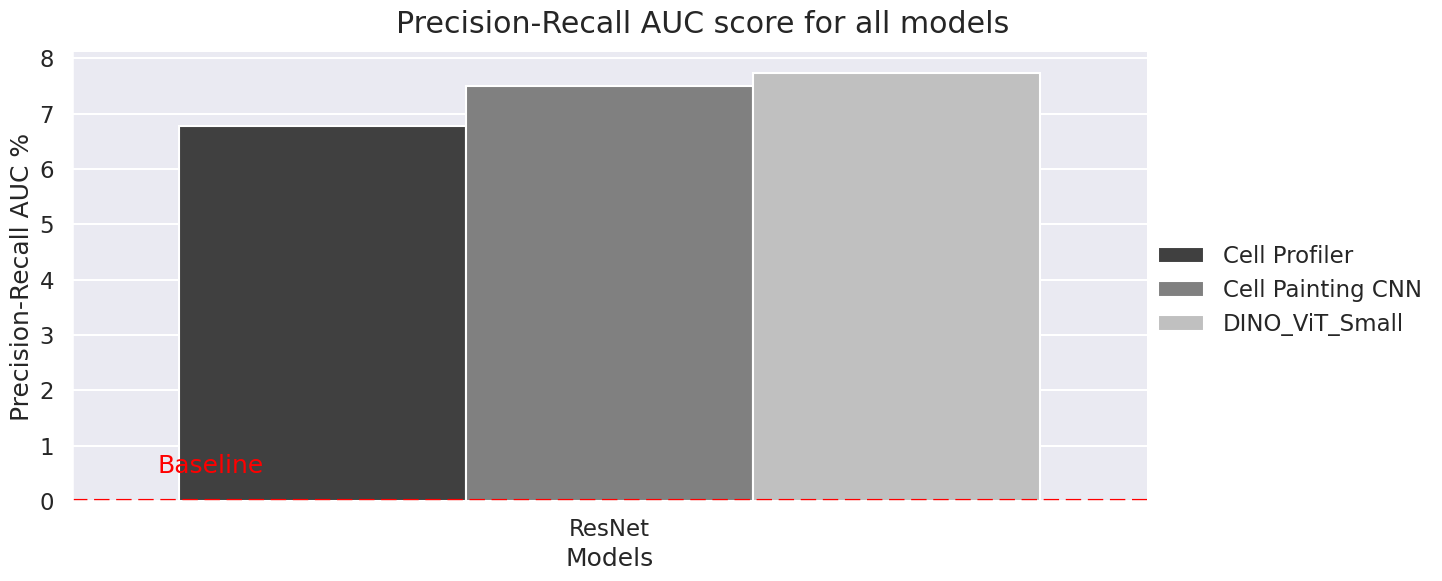

In [35]:
plot_model_predictions(df_pr_auc_normal, pr_baseline, "pr_auc_all_assays.png")

In [73]:
#number for the graph
print(df_pr_auc_normal)

               model  values       profile_tech
0       CellProfiler    6.57      Cell Profiler
1  Cell Painting CNN    7.48  Cell Painting CNN
2     DINO_ViT_Small    7.95     DINO ViT Small


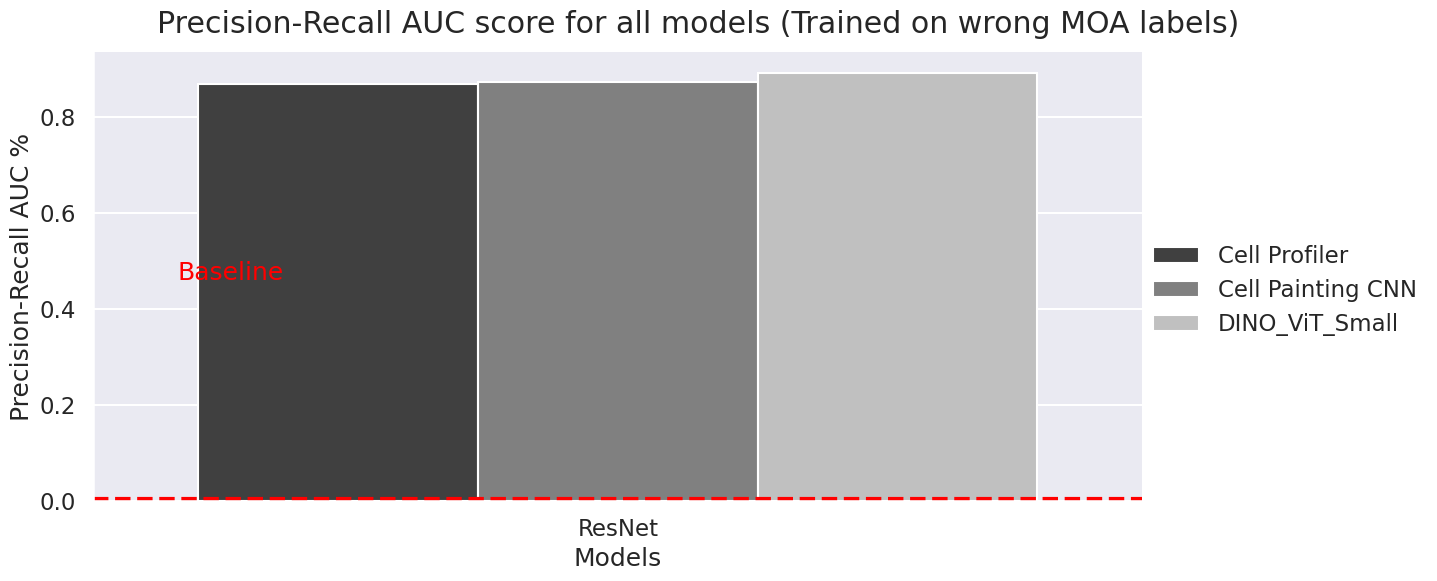

In [36]:
plot_model_predictions(df_pr_auc_shuffle, pr_baseline, "pr_auc_all_assays_wrong_labels.png", txt_cord_y = 0.46, 
                       title_label="Precision-Recall AUC score for all models (Trained on wrong MOA labels)")

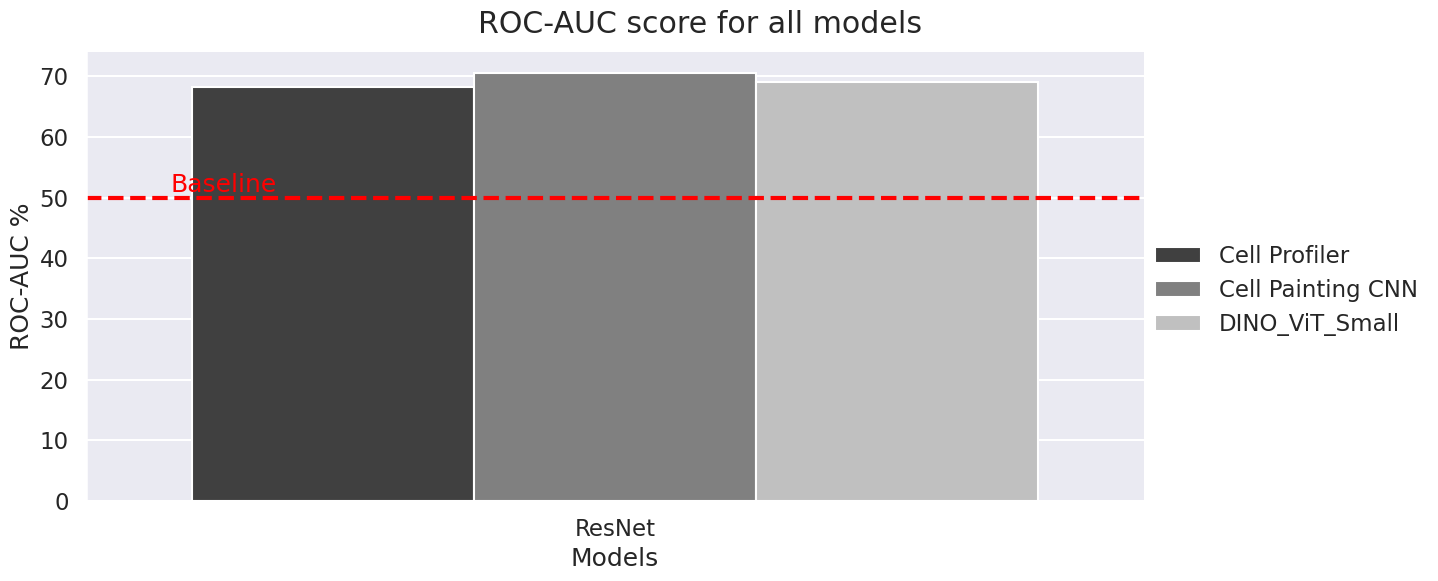

In [37]:
plot_model_predictions(df_roc_normal, 50, "roc_auc_all_assays.png", txt_cord_y = 51, y_label= "ROC-AUC %", title_label="ROC-AUC score for all models")

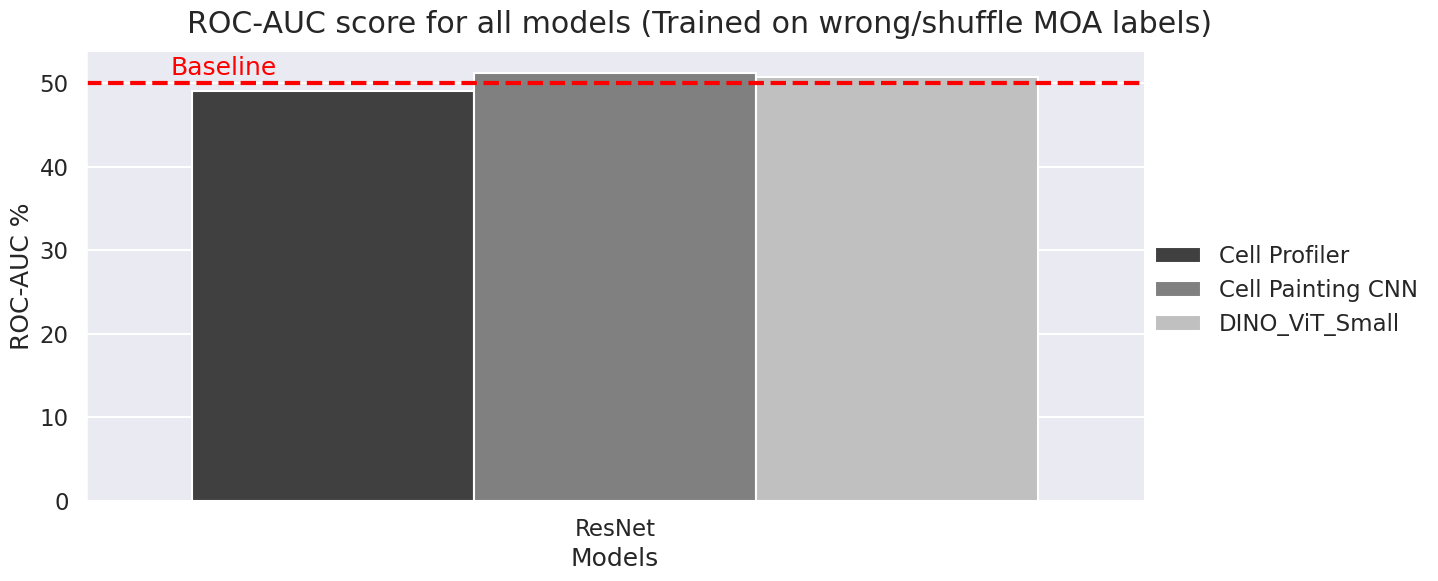

In [38]:
plot_model_predictions(df_roc_shuffle, 50, "roc_auc_all_assays_wrong_labels.png", txt_cord_y = 51, y_label= "ROC-AUC %", 
                       title_label="ROC-AUC score for all models (Trained on wrong/shuffle MOA labels)")

### - Test set MOA predictions

In [39]:
def evaluate_moa(actual, pred, moa):
  """Evaluate model predictions on an individual MOA basis using PR-AUC & ROC-AUC"""
  metrics_dict={}
  metrics_dict['roc_auc_score'] = roc_auc_score(actual.loc[:,moa], pred.loc[:,moa], average='macro')
  metrics_dict['pr_auc_score'] = average_precision_score(actual.loc[:,moa], pred.loc[:,moa], average="micro")
  return metrics_dict

In [40]:
moa_results = {}
for moa in val_moas:
  for idx, (assay_name, actual_df) in enumerate(zip(assays, targets_dfs)):
    for mdl, pred_df in zip(model_name, preds_all[idx]):
      model_score = {}
      score_name = moa + '_' +assay_name + mdl
      moa_eval_dict = evaluate_moa(actual_df, pred_df, moa)
      moa_results[score_name] = moa_eval_dict

In [41]:
df_moa_preds = pd.DataFrame([(k,k1,v1) for k,v in moa_results.items() for k1,v1 in v.items()], 
                              columns = ['id_name', 'metrics', 'values'])

In [42]:
df_moa_preds['moa'] = df_moa_preds['id_name'].apply(lambda x: x.split('_')[0])
df_moa_preds['model'] = df_moa_preds['id_name'].apply(lambda x: x.split('_')[-1])
df_moa_preds['profile_tech'] = df_moa_preds['id_name'].apply(lambda x: 'CP_L1000' if len(x.split('_')) == 4 else x.split('_')[1])

In [43]:
df_moa_preds['model'].unique()

array(['resnet', 'resnetshuf'], dtype=object)

In [44]:
df_moa_preds_normal = df_moa_preds[df_moa_preds['model'].isin(normal_models)].reset_index(drop=True)
df_moa_preds_shuffle = df_moa_preds[df_moa_preds['model'].isin(shuffle_models)].reset_index(drop=True)

In [45]:
def get_profile_tech_preds(df):
    """Get dataframes for each profiling assays"""
    df_cp = df[df['profile_tech'] == 'ViTS'].reset_index(drop=True)
    df_cp_cellpro = df[df['profile_tech'] == 'CellProfiler'].reset_index(drop=True)
    df_cp_CNN = df[df['profile_tech'] == 'CP-CNN'].reset_index(drop=True)

#     df_cp_subsample = df[df['profile_tech'] == 'CPsubsample'].reset_index(drop=True)
    # df_L1 = df[df['profile_tech'] == 'L1000'].reset_index(drop=True)
    # df_cp_L1 = df[df['profile_tech'] == 'CP_L1000'].reset_index(drop=True)
    return df_cp, df_cp_cellpro, df_cp_CNN

In [46]:
df_moa_cp_preds, df_moa_cp_preds_cellpro, df_moa_cp_preds_CNN = get_profile_tech_preds(df_moa_preds_normal)
df_moa_cp_shuf, df_moa_cp_shuf_cellpro, df_moa_cp_shuf_CNN = get_profile_tech_preds(df_moa_preds_shuffle)

In [47]:
def get_metric_preds(df_cp, df_cp_cellpro, df_cp_CNN):
    """Get PR-AUC scores for each profiling assays"""
    df_pr_cp = df_cp[df_cp['metrics'] == 'pr_auc_score'].copy()
    df_pr_cp_cellpro = df_cp_cellpro[df_cp_cellpro['metrics'] == 'pr_auc_score'].copy()
    df_pr_cp_CNN = df_cp_CNN[df_cp_CNN['metrics'] == 'pr_auc_score'].copy()
#     df_pr_cp_subsample = df_cp_subsample[df_cp_subsample['metrics'] == 'pr_auc_score'].copy()
    # df_pr_L1 = df_L1[df_L1['metrics'] == 'pr_auc_score'].copy()
    # df_pr_cp_L1 = df_cp_L1[df_cp_L1['metrics'] == 'pr_auc_score'].copy()
    return df_pr_cp, df_pr_cp_cellpro, df_pr_cp_CNN

In [48]:
df_pr_cp_preds, df_pr_cp_preds_cellpro, df_pr_cp_preds_CNN = get_metric_preds(df_moa_cp_preds, 
                                                                              df_moa_cp_preds_cellpro, 
                                                                              df_moa_cp_preds_CNN)

df_pr_cp_shuf, df_pr_cp_shuf_cellpro, df_pr_cp_shuf_CNN = get_metric_preds(df_moa_cp_shuf, 
                                                                           df_moa_cp_shuf_cellpro, 
                                                                           df_moa_cp_preds_CNN)

In [49]:
def top_moa_auc(df):
    """Choose the best model predictive scores among all model predictions for each MOA"""
    df_max_moa = df.groupby(['moa']).agg(['max'])
    df_max_moa.columns = df_max_moa.columns.droplevel(1)
    df_max_moa.rename_axis(None, axis=0, inplace = True)
    df_max_moa = df_max_moa.reset_index().rename(columns={"index": "moa"})
    df_moa_top_auc = df_max_moa.sort_values(by='values', ascending = False)
    df_moa_top_auc.reset_index(drop=True, inplace = True)
    df_moa_top_auc.drop(['id_name', 'model'], axis = 1, inplace = True)
    return df_moa_top_auc

In [50]:
df_top_moa_pr_cp = top_moa_auc(df_pr_cp_preds)
df_top_moa_pr_cp_cellpro = top_moa_auc(df_pr_cp_preds_cellpro)
df_top_moa_pr_cp_CNN = top_moa_auc(df_pr_cp_preds_CNN)

# df_top_moa_pr_cp_subsample = top_moa_auc(df_pr_cp_preds_subsample)
# df_top_moa_pr_L1 = top_moa_auc(df_pr_L1_preds)
# df_top_moa_pr_cp_L1 = top_moa_auc(df_pr_cp_L1_preds)

In [51]:
df_shuf_moa_pr_cp = top_moa_auc(df_pr_cp_shuf)
df_shuf_moa_pr_cp_cellpro = top_moa_auc(df_pr_cp_shuf_cellpro)
df_shuf_moa_pr_cp_CNN = top_moa_auc(df_pr_cp_shuf_CNN)

# df_shuf_moa_pr_cp_subsample = top_moa_auc(df_pr_cp_shuf_subsample)
# df_shuf_moa_pr_L1 = top_moa_auc(df_pr_L1_shuf)
# df_shuf_moa_pr_cp_L1 = top_moa_auc(df_pr_cp_L1_shuf)

In [52]:
moa_cp_baseline = np.mean(df_shuf_moa_pr_cp['values'])
moa_cp_baseline_cellpro = np.mean(df_shuf_moa_pr_cp_cellpro['values'])
moa_cp_baseline_CNN = np.mean(df_shuf_moa_pr_cp_CNN['values'])


# moa_cp_baseline_subsample = np.mean(df_shuf_moa_pr_cp_subsample['values'])
# moa_L1_baseline = np.mean(df_shuf_moa_pr_L1['values'])
# moa_cp_L1_baseline = np.mean(df_shuf_moa_pr_cp_L1['values'])

In [53]:
print(moa_cp_baseline)
print(moa_cp_baseline_cellpro)
print(moa_cp_baseline_CNN)

# print(moa_cp_baseline_subsample)
# print(moa_L1_baseline)
# print(moa_cp_L1_baseline)

0.010697175409239494
0.008188789330630853
0.09404639955400824


In [54]:
df_moa_pr_cp = df_top_moa_pr_cp[['moa', 'values']].copy()
df_moa_pr_cp_cellpro = df_top_moa_pr_cp_cellpro[['moa', 'values']].copy()
df_moa_pr_cp_CNN = df_top_moa_pr_cp_CNN[['moa', 'values']].copy()

# df_moa_pr_cp_subsample = df_top_moa_pr_cp_subsample[['moa', 'values']].copy()
# df_moa_pr_L1 = df_top_moa_pr_L1[['moa', 'values']].copy()
# df_moa_pr_cp_L1 = df_top_moa_pr_cp_L1[['moa', 'values']].copy()

In [55]:
df_moa_pr_cp.rename(columns={"values": "ViTS_values"}, inplace = True)
df_moa_pr_cp_cellpro.rename(columns={"values": "cell_profiler_values"}, inplace = True)
df_moa_pr_cp_CNN.rename(columns={"values": "CNN_values"}, inplace = True)

# df_moa_pr_cp_subsample.rename(columns={"values": "cp_values_subsample"}, inplace = True)
# df_moa_pr_L1.rename(columns={"values": "L1_values"}, inplace = True)
# df_moa_pr_cp_L1.rename(columns={"values": "cp_L1_values"}, inplace = True)

In [56]:
df_moa_prs = pd.merge(df_moa_pr_cp, df_moa_pr_cp_cellpro, on='moa')
df_moa_prs = pd.merge(df_moa_prs, df_moa_pr_cp_CNN, on='moa')
# df_moa_prs = pd.merge(df_moa_prs, df_moa_pr_cp_base, on='moa')


In [57]:
df_moa_prs.head(20)

,moa,ViTS_values,cell_profiler_values,CNN_values
0,plk inhibitor,1.000000,1.000000,1.000000
1,pkc activator,1.000000,0.876923,1.000000
2,proteasome inhibitor,1.000000,1.000000,1.000000
3,mek inhibitor,1.000000,1.000000,1.000000
4,hsp inhibitor,0.980909,0.703678,0.956667
5,dihydrofolate reductase inhibitor,0.966667,1.000000,1.000000
6,raf inhibitor,0.831845,0.571951,0.873124
7,mdm inhibitor,0.821277,0.850000,0.911111
8,inosine monophosphate dehydrogenase inhibitor,0.761111,0.833333,0.942857
9,aurora kinase inhibitor,0.670214,0.880451,0.492355


In [58]:
# Output individual MOA Precision Recall
output_file = pathlib.Path(f"{result_dir}/moa_precision_recall_resnet_final_v3.csv")
df_moa_prs.to_csv(output_file, index=False)

### - Plot Individual MOA predictions

##### - Note: The red horizontal and vertical lines are PR-AUC baseline score based on getting the average shuffle moa predictions across all MOAs for each profiling assays i.e. Cell Painting (CP), L1000, & Integrated CP & L1000

In [59]:
def plot_moa_predictions(df, file_name, col_x, col_y, x_label, y_label, title_label, baseline_x, baseline_y, path=model_preds_figures):
  """Plot MOA PR-AUC scores for profiling assays"""
  if not os.path.exists(path):
    os.mkdir(path)
  value=((df[col_y] > 0.2) | (df[col_x] > 0.2))
  df['color']= np.where(value==True, "purple", "skyblue")
  plt.figure(figsize=(18,10))
  reg_plt=sns.regplot(data=df, x=col_x, y=col_y, fit_reg=False, marker="o", color="skyblue", 
                      scatter_kws={'facecolors':df['color'], 's':100})
  reg_plt.set_title(f"{title_label}, annotating MOAs above 0.2 PR-AUC scores")
  reg_plt.set(xlabel=x_label, ylabel=y_label)
  plt.axhline(baseline_y, ls='--', linewidth=3, color='red', alpha=0.5)
  plt.axvline(baseline_x, ls='--', linewidth=3, color='red', alpha=0.5)
  ##add annotations one by one with a loop
  text = [reg_plt.text(df[col_x][line], df[col_y][line], df.moa[line],
                       fontdict=dict(color= 'black',size=11.5),) for line in range(df.shape[0]) 
                       if (((df[col_x][line] > 0.2) | (df[col_y][line] > 0.2)))]
  adjust_text(text, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
  plt.savefig(os.path.join(path, file_name))
  plt.show()

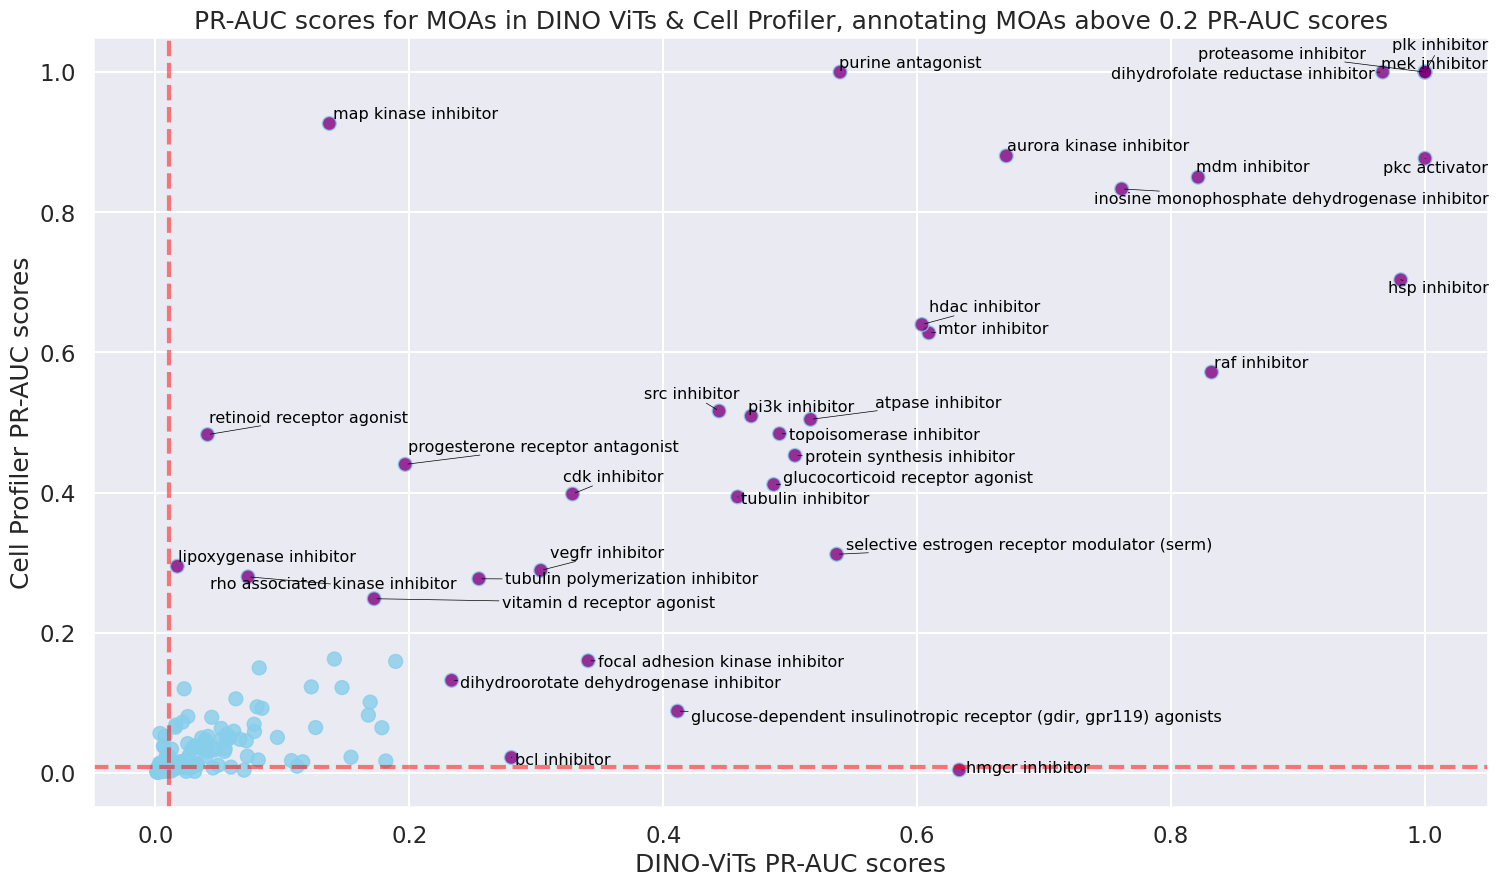

In [60]:
plot_moa_predictions(df_moa_prs, 
                     'pr_auc_moas_DINO_vit_small_vs_Cell_Profiler.png', 
                     'ViTS_values', 
                     'cell_profiler_values', 
                     "DINO-ViTs PR-AUC scores", 
                     "Cell Profiler PR-AUC scores", 
                     "PR-AUC scores for MOAs in DINO ViTs & Cell Profiler", 
                     moa_cp_baseline, 
                     moa_cp_baseline_cellpro)

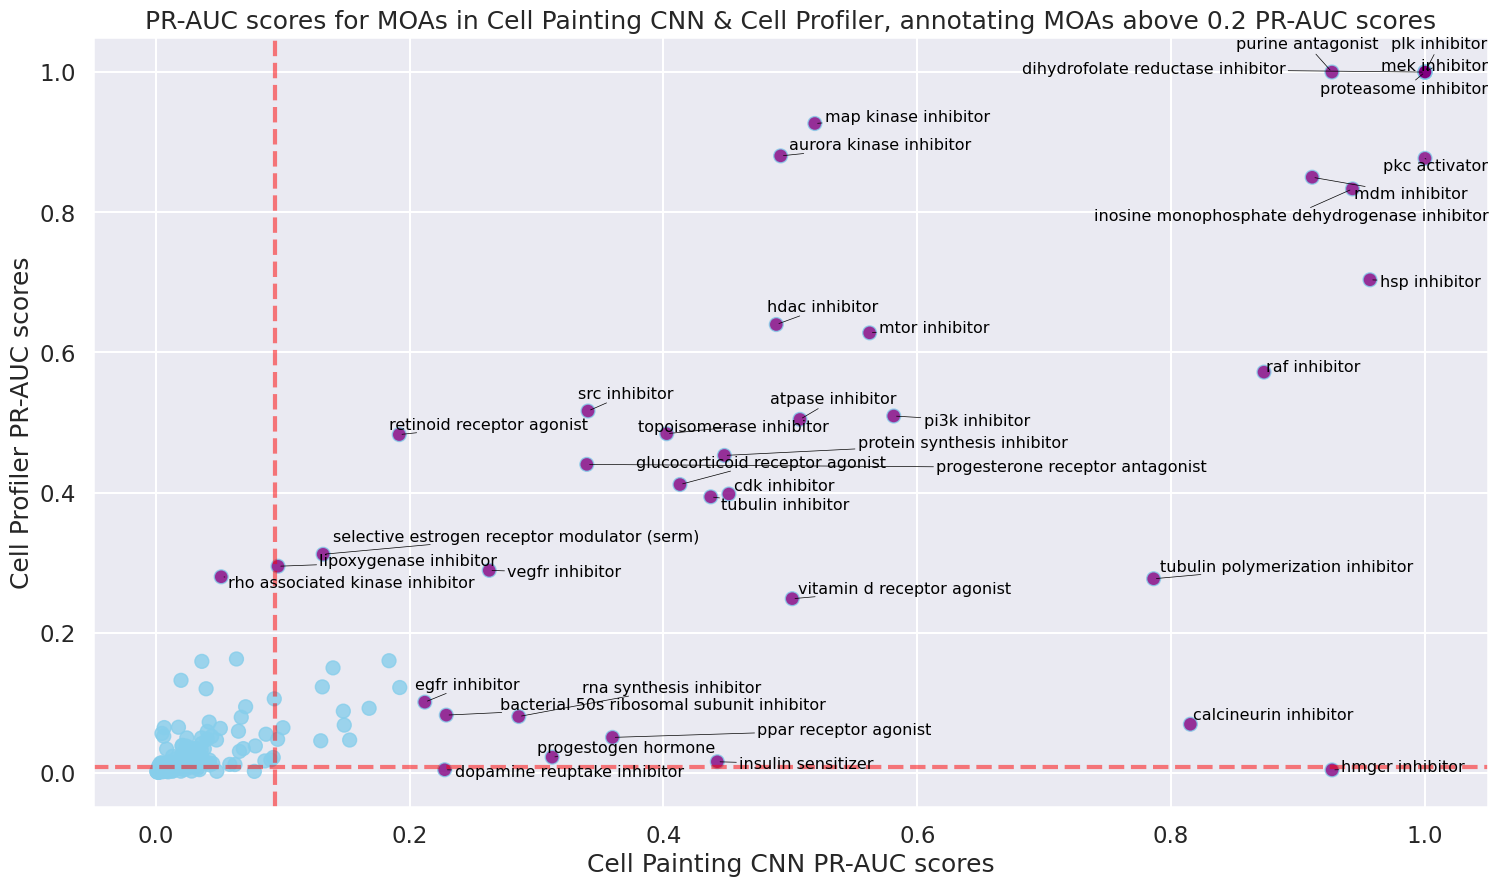

In [61]:
plot_moa_predictions(df_moa_prs, 
                     'pr_auc_moas_Cell_Painting_CNN_vs_Cell_Profiler.png', 
                     'CNN_values', 
                     'cell_profiler_values', 
                     "Cell Painting CNN PR-AUC scores", 
                     "Cell Profiler PR-AUC scores", 
                     "PR-AUC scores for MOAs in Cell Painting CNN & Cell Profiler", 
                     moa_cp_baseline_CNN, 
                     moa_cp_baseline_cellpro)

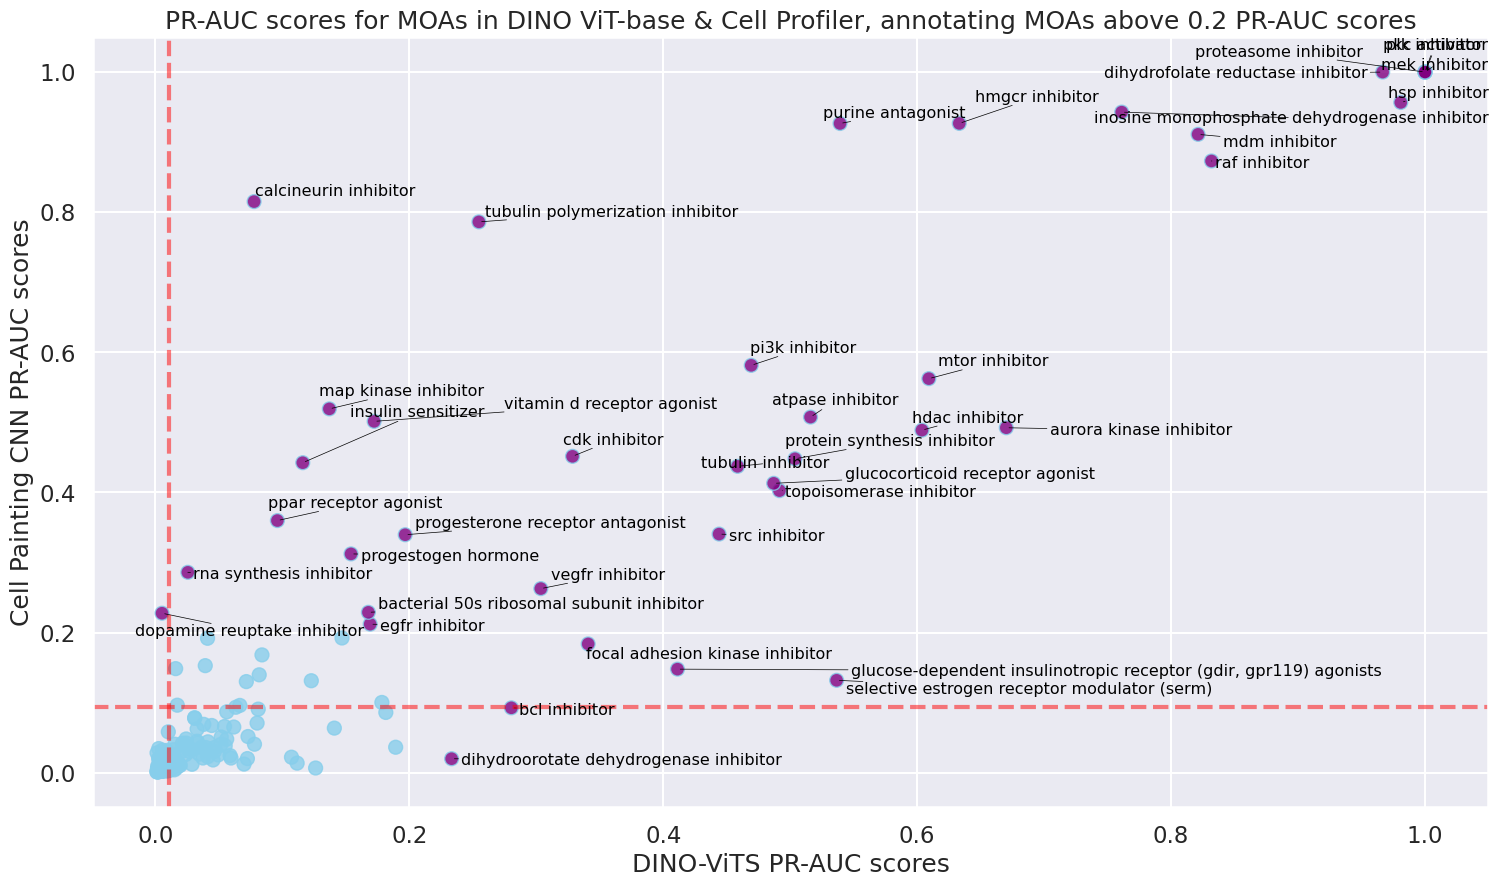

In [62]:
plot_moa_predictions(df_moa_prs, 
                     'pr_auc_moas_DINO_vit_small_vs_Cell_Painting_CNN.png', 
                     'ViTS_values', 
                     'CNN_values',
                     "DINO-ViTS PR-AUC scores",
                     "Cell Painting CNN PR-AUC scores", 
                     "PR-AUC scores for MOAs in DINO ViT-base & Cell Profiler", 
                     moa_cp_baseline, 
                     moa_cp_baseline_CNN)